# General form regression using DeepLearning

In [168]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [169]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


## Normalization

In [170]:
X = np.linspace(0, 10, 1000)
Y = 3 * np.sin(0.5 * X * X) + X - 10

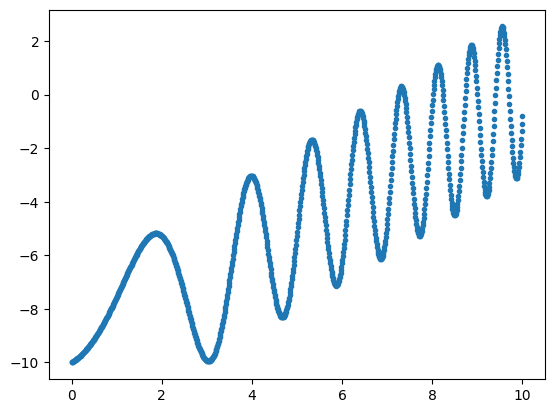

In [171]:
plt.scatter(X, Y, marker='.')
plt.show()

In [172]:
def normalize(X, Y, size: int = 100):
    """
    Min-max normalization.
    """

    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = np.min(Y), np.max(Y)

    idx = np.round(np.linspace(0, len(X) - 1, size)).astype(int)
    X_norm = ((X - x_min) / (x_max - x_min))[idx]
    Y_norm = ((Y - y_min) / (y_max - y_min))[idx]
    return X_norm, Y_norm

In [173]:
def normalize(X, Y, size: int = 100):
    """
    Z-score normalization (standardization).
    """

    idx = np.round(np.linspace(0, len(X) - 1, size)).astype(int)
    X_norm = X[idx]
    Y_norm = ((Y - np.mean(Y)) / np.std(Y))[idx]
    return X_norm, Y_norm

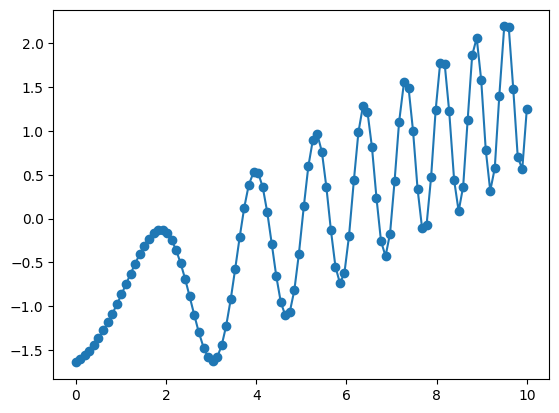

In [174]:
X_norm, Y_norm = normalize(X, Y)
plt.plot(X_norm, Y_norm)
plt.scatter(X_norm, Y_norm)
plt.show()

## Generating the dataset

In [175]:
from symreg.random import random_formula, RandomOptions

- Sinus, cosinus
- Tangent
- Divide, product
- Add, subtract
- Sqrt
- Log

```
  BINARY OPERATORS                   UNARY OPERATORS
 ADD/SUB | MUL/DIV   |   EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG
```

In [194]:
from symreg.formula import ExpressionVisitor, BinaryOp, UnaryOp

class VectorVisitor(ExpressionVisitor):
    def __init__(self):
        super().__init__()
        self.vector = np.zeros(9)

    def visit_binary_expr(self, expr):
        super().visit_binary_expr(expr)

        match expr.op:
            case BinaryOp.ADD | BinaryOp.SUB:
                self.vector[0] = 1
            case BinaryOp.MUL | BinaryOp.DIV:
                self.vector[1] = 1
            case _:
                raise NotImplementedError
    
    def visit_unary_expr(self, expr):
        super().visit_unary_expr(expr)

        match expr.op:
            case UnaryOp.EXP:
                self.vector[2] = 1
            case UnaryOp.SIN:
                self.vector[3] = 1
            case UnaryOp.TAN:
                self.vector[4] = 1
            case UnaryOp.ASIN:
                self.vector[5] = 1
            case UnaryOp.ATAN:
                self.vector[6] = 1
            case UnaryOp.SQRT:
                self.vector[7] = 1
            case UnaryOp.LOG:
                self.vector[8] = 1


def generate_formula_dataset(n: int, sample_count: int = 5, x_range = (-10, 10)):
    X = np.linspace(x_range[0], x_range[1], sample_count)

    options = RandomOptions()
    options.definition_set = X

    data = []
    labels = []

    i = 0
    while i < n:
        formula = random_formula(options)
        Y = formula(X)

        if isinstance(Y, float):
            Y = np.array([Y] * len(X))

        if np.any(np.isnan(Y)):
            continue

        X_norm, Y_norm = normalize(X, Y, sample_count)
        if np.any(np.isnan(Y_norm)):
            continue

        visitor = VectorVisitor()
        visitor.accept(formula.expr)
        data.append(Y_norm)
        labels.append(visitor.vector)
        i += 1

        if i % 100 == 0:
            print(f"Generated [{i}]")

    data = torch.tensor(data, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)

    data = data.unsqueeze(1)

    return data, labels


In [195]:
generate_formula_dataset(3)

(tensor([[[-0.6512, -0.3390,  1.9804, -0.3390, -0.6512]],
 
         [[ 1.4469,  0.6376,  0.0000, -0.6376, -1.4469]],
 
         [[-0.5553, -0.5540, -0.5383, -0.3462,  1.9938]]]),
 tensor([[0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0.]]))

## Training

In [196]:
INPUT_SAMPLES = 100
OUTPUT_FEATURES = 9

In [197]:
n_train = 200
train_data, train_labels = generate_formula_dataset(n_train, INPUT_SAMPLES)
dataset = TensorDataset(train_data, train_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Generated [100]
Generated [200]


c:\Users\gruni\Desktop\ENS\M1\Machine Learning Physique\MLP-SymReg\symreg\formula.py:180: RuntimeWarning: overflow encountered in exp
  return self.op.value(operand)
C:\Users\gruni\AppData\Local\Temp\ipykernel_13048\1416907520.py:8: RuntimeWarning: invalid value encountered in subtract
  Y_norm = ((Y - np.mean(Y)) / np.std(Y))[idx]
c:\Users\gruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\gruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\gruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


C:\Users\gruni\AppData\Local\Temp\ipykernel_13048\1555589320.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


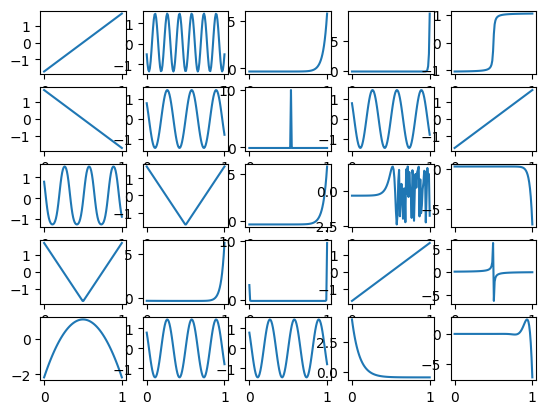

In [198]:
WIDTH, HEIGHT = 5, 5
f, ax = plt.subplots(WIDTH, HEIGHT)
for i in range(WIDTH):
    for j in range(HEIGHT):
        idx = j * WIDTH + i
        ax[i][j].plot(np.linspace(0, 1, INPUT_SAMPLES), dataset[idx][0].flatten())
f.show()

In [239]:
def train_model(model, dataloader, epochs):
  model.to(device)
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-1)
  loss_fn = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    running_loss, running_acc = 0.0, 0
    for _, data in enumerate(dataloader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      preds = (outputs >= 1)
      running_acc += torch.sum(preds == labels).item()
      running_loss += loss.item()

    print(f"[TRAIN epoch {epoch}]: Loss: {running_loss/n_train} Accuracy: {running_acc/n_train/OUTPUT_FEATURES}")

In [240]:
def test_model(model, dataloader):
  model.to(device)
  model.eval()

  loss_fn = nn.CrossEntropyLoss()

  running_loss, running_acc = 0.0, 0
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)

      preds = (outputs >= 1)
      running_acc += torch.sum(preds == labels).item()
      running_loss += loss.item()

  print(f"[TEST]: Loss: {running_loss/n_train} Accuracy: {running_acc/n_train/OUTPUT_FEATURES}")

In [241]:
model = nn.Sequential(
    nn.Flatten(),
    # MLP layers
    nn.Linear(INPUT_SAMPLES, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, OUTPUT_FEATURES)
)

train_model(model, dataloader, 15)
test_model(model, dataloader)

[TRAIN epoch 0]: Loss: 0.1414709746837616 Accuracy: 0.7883333333333333
[TRAIN epoch 1]: Loss: 0.1390674602985382 Accuracy: 0.7883333333333333
[TRAIN epoch 2]: Loss: 0.14588429689407348 Accuracy: 0.7883333333333333
[TRAIN epoch 3]: Loss: 0.13817908525466918 Accuracy: 0.7883333333333333
[TRAIN epoch 4]: Loss: 0.1366059398651123 Accuracy: 0.7883333333333333
[TRAIN epoch 5]: Loss: 0.13750238895416259 Accuracy: 0.7883333333333333
[TRAIN epoch 6]: Loss: 0.13844333291053773 Accuracy: 0.7883333333333333
[TRAIN epoch 7]: Loss: 0.13490078926086427 Accuracy: 0.7883333333333333
[TRAIN epoch 8]: Loss: 0.1348325002193451 Accuracy: 0.7883333333333333
[TRAIN epoch 9]: Loss: 0.13248239398002626 Accuracy: 0.7883333333333333
[TRAIN epoch 10]: Loss: 0.1276218104362488 Accuracy: 0.7883333333333333
[TRAIN epoch 11]: Loss: 0.12854329943656922 Accuracy: 0.7883333333333333
[TRAIN epoch 12]: Loss: 0.12714112520217896 Accuracy: 0.7888888888888889
[TRAIN epoch 13]: Loss: 0.13054923534393312 Accuracy: 0.8183333333

In [244]:
# Define the CNN model
class CurveOperatorCNN(nn.Module):
    def __init__(self, num_classes=4, input_size=100):
        super(CurveOperatorCNN, self).__init__()
        
        # 1st Conv layer: input channels=1 (since it's a single curve), output channels=16
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        
        # 2nd Conv layer: input channels=16, output channels=32
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        
        # 3rd Conv layer: input channels=32, output channels=64
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers after flattening
        self.fc1 = nn.Linear(64, 512)  # assuming 3 maxpools reduce the input size
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, num_classes)  # Output layer for classification

        # MaxPooling layer
        self.pool = nn.MaxPool1d(2, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Apply 1st convolutional layer, followed by batchnorm, ReLU, and max-pooling
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        
        # Apply 2nd convolutional layer
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        
        # Apply 3rd convolutional layer
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))

        x = self.global_pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten for FC layer
        
        # Fully connected layers
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

model = CurveOperatorCNN(OUTPUT_FEATURES, INPUT_SAMPLES)
train_model(model, dataloader, 50)
test_model(model, dataloader)

[TRAIN epoch 0]: Loss: 0.15058018565177916 Accuracy: 0.7883333333333333
[TRAIN epoch 1]: Loss: 0.14290011286735535 Accuracy: 0.7883333333333333
[TRAIN epoch 2]: Loss: 0.1403996205329895 Accuracy: 0.7883333333333333
[TRAIN epoch 3]: Loss: 0.1344808316230774 Accuracy: 0.7883333333333333
[TRAIN epoch 4]: Loss: 0.12995508790016175 Accuracy: 0.7916666666666666
[TRAIN epoch 5]: Loss: 0.13092376589775084 Accuracy: 0.7922222222222222
[TRAIN epoch 6]: Loss: 0.12994465708732605 Accuracy: 0.7966666666666666
[TRAIN epoch 7]: Loss: 0.12747930645942687 Accuracy: 0.8
[TRAIN epoch 8]: Loss: 0.1210826063156128 Accuracy: 0.8094444444444444
[TRAIN epoch 9]: Loss: 0.12761303305625915 Accuracy: 0.8272222222222223
[TRAIN epoch 10]: Loss: 0.11444881081581115 Accuracy: 0.8405555555555556
[TRAIN epoch 11]: Loss: 0.11970575451850891 Accuracy: 0.8427777777777777
[TRAIN epoch 12]: Loss: 0.11455690860748291 Accuracy: 0.8405555555555556
[TRAIN epoch 13]: Loss: 0.11607023000717163 Accuracy: 0.8444444444444444
[TRAIN

(-4.266684455492863 BinaryOp.MUL x)
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
tensor([[ 0.1216,  1.7392,  0.3956,  0.3718, -0.5393, -1.3045, -0.4120,  0.1816,
         -0.8893]], grad_fn=<AddmmBackward0>)
tensor([[False,  True, False, False, False, False, False, False, False]])
tensor(1.)


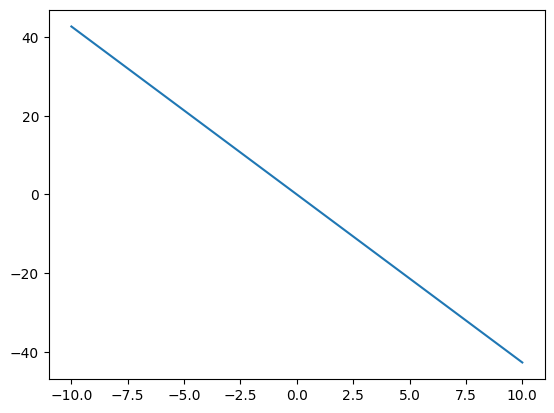

In [243]:
import torch.types


X = np.linspace(-10, 10, INPUT_SAMPLES)
options = RandomOptions()
options.definition_set = X

formula = random_formula(options)
visitor = VectorVisitor()
visitor.accept(formula.expr)
print(formula)
print(visitor.vector)

Y = formula(X)

X_norm, Y_norm = normalize(X, Y, INPUT_SAMPLES)
Y_norm = torch.tensor(Y_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
print(model(Y_norm))

preds = model(Y_norm) >= 1
print(preds)
print(torch.sum(preds == visitor.vector) / 9)

plt.plot(X, Y)
plt.show()